# Identify the sentiments

## import lib

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

## import dataset

In [ ]:
train = pd.read_csv(r'/content/drive/MyDrive/hackathondatascience/analiticsvidya/Identify the Sentiments/train_2kmZucJ.csv')
test = pd.read_csv(r'/content/drive/MyDrive/hackathondatascience/analiticsvidya/Identify the Sentiments/test_oJQbWVk.csv')
submission = pd.read_csv(r'/content/drive/MyDrive/hackathondatascience/analiticsvidya/Identify the Sentiments/sample_submission_LnhVWA4.csv')
pd.set_option('display.max_colwidth',200)

### dataset details visualization

In [ ]:
train.shape, test.shape, submission.shape

((7920, 3), (1953, 2), (1953, 2))

In [ ]:
train.head(7)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
5,6,1,iPhone software update fucked up my phone big time Stupid iPhones
6,7,0,Happy for us .. #instapic #instadaily #us #sony #xperia #xperiaZ https://instagram.com/p/z9qGfWlvj7/


In [ ]:
# prompt: undersampling

train_pos = train[train['Sentiment'] == 'Positive']
train_neg = train[train['Sentiment'] == 'Negative']
train_pos_undersampled = train_pos.sample(n=train_neg.shape[0], replace=True)
train_undersampled = pd.concat([train_pos_undersampled, train_neg], axis=0)
train_undersampled.shape


In [ ]:
train['label'].value_counts()

0    5894
1    2026
Name: label, dtype: int64

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Load your dataset. Assuming your dataset is a CSV file named "train.csv":


# Separate your features and target variable:
X = train['tweet']
y = train['label']



ros = RandomOverSampler(random_state=0)

# Fit the sampler and create the resampled dataset:
X, y = ros.fit_resample(X.values.reshape(-1, 1), y)
# Convert X and y back to DataFrame
X_df = pd.DataFrame(X, columns=['tweet'])
y_df = pd.DataFrame(y, columns=['label'])

# Concatenate X_df and y_df to form the new DataFrame
train = pd.concat([y_df,X_df], axis=1)

# Now, you can use `X_resampled` and `y_resampled` to train your model.
train['label'].value_counts()

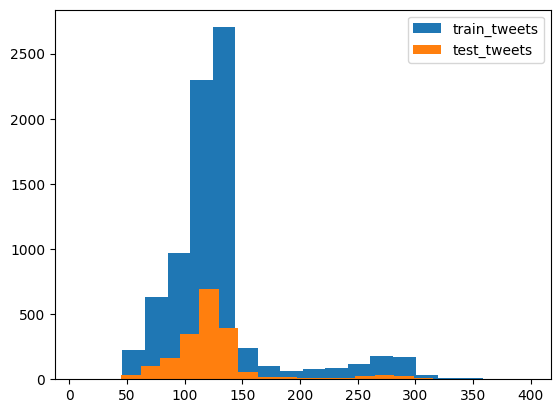

In [ ]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()
plt.hist(length_train, bins=20,label='train_tweets')
plt.hist(length_test,bins=20,label='test_tweets')
plt.legend()
plt.show()

### data processing

In [ ]:
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

In [ ]:
train[train['label']==0].head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
6,0,Happy for us .. #instapic #instadaily #us #sony #xperia #xperiaZ https://instagram.com/p/z9qGfWlvj7/


In [ ]:
train[train['label']==1].head()

,label,tweet
4,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
5,1,iPhone software update fucked up my phone big time Stupid iPhones
10,1,hey #apple when you make a new ipod dont make it a new color or .2inches thinner make it not crash every five fuckin minite.
11,1,Ha! Not heavy machinery but it does what I need it to. @Apple really dropped the ball with that design. #drinkyourhaterade
12,1,Contemplating giving in to the iPhone bandwagon simply because #Cellcom has no new Androids #depressing #IDontWantTo


## text preprocessing

### text cleaning

In [ ]:
# lower casing, remove links and unwanted text
def clean_tweet(text):

    # lower-case all characters
    text=text.lower()

    # remove twitter handles
    text= re.sub(r'@\S+', '',text)

    # remove urls
    text= re.sub(r'http\S+', '',text)
    text= re.sub(r'pic.\S+', '',text)



    # regex only keeps characters
    text= re.sub(r"[^a-zA-Z+']", ' ',text)


    # regex removes repeated spaces, strip removes leading and trailing spaces
    text= re.sub("\s[\s]+", " ",text).strip()
    return text

train['tweet'] =train['tweet'].apply(lambda x: clean_tweet(x))
test['tweet'] =test['tweet'].apply(lambda x: clean_tweet(x))
train.head()


,label,tweet
0,0,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,0,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias
2,0,we love this would you go talk makememories unplug relax iphone smartphone wifi connect
3,0,i'm wired i know i'm george i was made that way iphone cute daventry home
4,1,what amazing service apple won't even talk to me about a question i have unless i pay them for their stupid support


In [ ]:

X = train.drop('label',axis=1)
y = train['label']

### vocab creattoion

In [ ]:
### Vocabulary size
voc_size=10000

In [ ]:
messages=X.copy()
messages['tweet'][1]

'finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias'

In [ ]:
messages.reset_index(inplace=True)

### stop word removel


In [ ]:
import nltk
from nltk.corpus import stopwords

### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['tweet'][i])
    review = review.lower()
    review = review.split()

    review = ' '.join(review)
    corpus.append(review)

### onehot encoding

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [ ]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 7124 3960 1362]
 [   0    0    0 ... 3563 3886 6642]
 [   0    0    0 ...  455 3728 5288]
 ...
 [9906 1443  884 ... 8778 9846 2085]
 [   0    0    0 ... 6611 3886  548]
 [   0    0    0 ... 4287 3738 3056]]


In [ ]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0, 1225, 5075, 4247,
       1403, 2382, 4289, 7945, 8847, 3317, 7124, 3960, 1362], dtype=int32)

# model creation

## LSTM model

In [ ]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 40)            400000    
                                                                 
 dropout_7 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_8 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 456501 (1.74 MB)
Trainable params: 456501 (1.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
len(embedded_docs),y.shape

(7920, (7920,))

In [ ]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

### train test split dataset

In [ ]:


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

### model fit

In [ ]:
### Finally Training
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=128)

Epoch 1/15
42/42 [==============================] - 9s 130ms/step - loss: 0.5258 - accuracy: 0.7584 - val_loss: 0.3893 - val_accuracy: 0.8175
Epoch 2/15
42/42 [==============================] - 3s 62ms/step - loss: 0.2962 - accuracy: 0.8771 - val_loss: 0.2710 - val_accuracy: 0.8791
Epoch 3/15
42/42 [==============================] - 2s 53ms/step - loss: 0.2053 - accuracy: 0.9152 - val_loss: 0.2570 - val_accuracy: 0.8856
Epoch 4/15
42/42 [==============================] - 2s 48ms/step - loss: 0.1569 - accuracy: 0.9372 - val_loss: 0.2709 - val_accuracy: 0.8829
Epoch 5/15
42/42 [==============================] - 1s 29ms/step - loss: 0.1204 - accuracy: 0.9565 - val_loss: 0.3299 - val_accuracy: 0.8741
Epoch 6/15
42/42 [==============================] - 2s 60ms/step - loss: 0.0899 - accuracy: 0.9710 - val_loss: 0.3510 - val_accuracy: 0.8673
Epoch 7/15
42/42 [==============================] - 1s 32ms/step - loss: 0.0735 - accuracy: 0.9768 - val_loss: 0.5415 - val_accuracy: 0.8596
Epoch 8/15
4

### predict the sentiment using threshold

In [ ]:
def predicter(model, x, threshold= 0.0028411177918314934):
    # Make a prediction
    pred = model.predict(x)
    # Apply the threshold
    pred = (pred >= threshold).astype(int)
    return pred
y_pred = predicter(model, X_test)


82/82 [==============================] - 1s 3ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc

def find_best_threshold(model, x, y):
    # Get the model's prediction probabilities
    pred_probs = model.predict(x)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs)

    # Calculate the AUC
    auc_score = auc(fpr, tpr)

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold, auc_score

82/82 [==============================] - 0s 3ms/step
Optimal threshold for training data: 0.1690712869167328
Optimal threshold for test data: 0.0022973085287958384


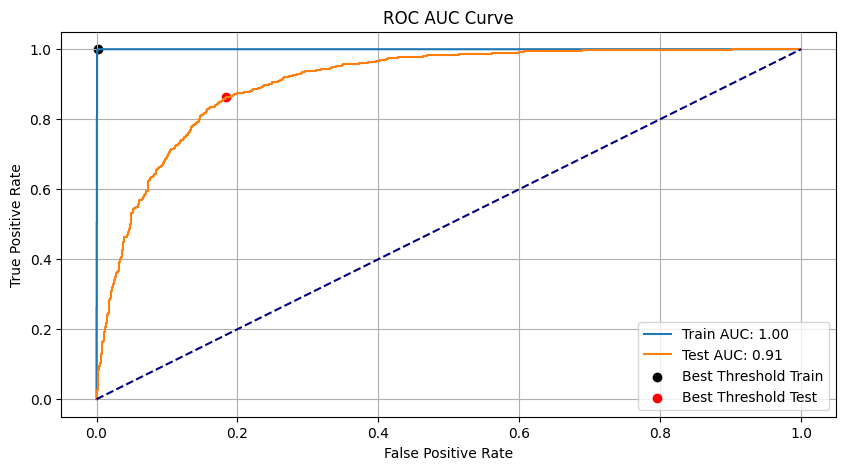

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_auc_curve(model, X_train, Y_train, X_test, Y_test):
    # Calculate the ROC curve points
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, y_train_pred)
    fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, y_test_pred)

    # Calculate the AUC (Area Under Curve)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    # Find the optimal threshold
    optimal_idx_train = np.argmax(tpr_train - fpr_train)
    optimal_threshold_train = thresholds_train[optimal_idx_train]
    optimal_idx_test = np.argmax(tpr_test - fpr_test)
    optimal_threshold_test = thresholds_test[optimal_idx_test]

    print(f'Optimal threshold for training data: {optimal_threshold_train}')
    print(f'Optimal threshold for test data: {optimal_threshold_test}')

    # Plot the ROC curve
    plt.figure(figsize=(10, 5))
    plt.plot(fpr_train, tpr_train, label=f'Train AUC: {auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC: {auc_test:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.scatter(fpr_train[optimal_idx_train], tpr_train[optimal_idx_train], marker='o', color='black', label='Best Threshold Train')
    plt.scatter(fpr_test[optimal_idx_test], tpr_test[optimal_idx_test], marker='o', color='red', label='Best Threshold Test')
    plt.title('ROC AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Call the function
plot_roc_auc_curve(model, X_train, y_train, X_test, y_test)


In [ ]:
optimal_threshold, auc_score = find_best_threshold(model, X_test, y_test)
print(f'Optimal threshold: {optimal_threshold}')
print(f'AUC score: {auc_score}')

82/82 [==============================] - 0s 3ms/step
Optimal threshold: 0.0022973085287958384
AUC score: 0.9075533106870366


### evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
print(f'confusion_matrix: {confusion_matrix(y_test,y_pred)}')

confusion_matrix: [[1568  338]
 [ 104  604]]


In [ ]:
from sklearn.metrics import accuracy_score
print(f'accuracy_score: {accuracy_score(y_test,y_pred)}')

accuracy_score: 0.8309104820198929


### model saving

In [ ]:
# saving model
filename = 'nlp_model.h5'
model.save(filename)


In [ ]:
Z = test
### Vocabulary size
voc_size=10000

messages=Z.copy()
messages['tweet'][2]

"i'd like to puts some cd roms on my ipad is that possible ' yes but wouldn't that block the screen"

In [ ]:
messages.reset_index(inplace=True)

In [ ]:
import nltk
from nltk.corpus import stopwords

### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):

    review = re.sub('[^a-zA-Z]', ' ', messages['tweet'][i])
    review = review.lower()
    review = review.split()

    review = ' '.join(review)
    corpus.append(review)

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
onehot_repr=[one_hot(words,voc_size)for words in corpus]

In [ ]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 1295  597 9007]
 [   0    0    0 ... 6566 2522 1182]
 [3002 6251 2792 ... 2090 7861  441]
 ...
 [6096 6612 8341 ... 6095  597 1362]
 [   0    0    0 ... 3951  597 6251]
 [   0    0    0 ... 2766  348 8087]]


In [ ]:
pred = predict(model,embedded_docs)

62/62 [==============================] - 0s 2ms/step


In [ ]:
submission['label'] = pred
submission.to_csv(f'submission.csv',index=False)

In [ ]:
submission

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1
...,...,...
1948,9869,1
1949,9870,0
1950,9871,1
1951,9872,1


## fasttext model

### download and configurations

In [ ]:
# !wget -P /content/drive/MyDrive/hackathondatascience/analiticsvidya/Identify\ the\ Sentiments https://github.com/facebookresearch/fastText/archive/v0.9.2.zip

In [ ]:
# !unzip /content/drive/MyDrive/hackathondatascience/analiticsvidya/Identify\ the\ Sentiments/v0.9.2.zip -d /content/drive/MyDrive/hackathondatascience/analiticsvidya/Identify\ the\ Sentiments


In [ ]:
# !pip install -e /content/drive/MyDrive/hackathondatascience/analiticsvidya/Identify\ the\ Sentiments/fastText-0.9.2/

### text processing for the case

In [ ]:
ft_train

,id,label,tweet,ft_trainingprocessed
0,1,__label____label__0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,__label____label__0 fingerprint pregnancy test https goo gl h1mfqv android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,__label____label__0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,__label____label__0 finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias http instagram com p yget5jc6jm
2,3,__label____label__0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,__label____label__0 we love this would you go talk makememories unplug relax iphone smartphone wifi connect http fb me 6n3lsupcu
3,4,__label____label__0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,__label____label__0 i'm wired i know i'm george i was made that way iphone cute daventry home http instagr am p li_5_ujs4k
4,5,__label____label__1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,__label____label__1 what amazing service apple won't even talk to me about a question i have unless i pay them 19 95 for their stupid support
...,...,...,...,...
7915,7916,__label____label__0,Live out loud #lol #liveoutloud #selfie #smile #sony #music #headphones https://instagram.com/p/5spiNsJ_c9/,__label____label__0 live out loud lol liveoutloud selfie smile sony music headphones https instagram com p 5spinsj_c9
7916,7917,__label____label__0,"We would like to wish you an amazing day! Make every minute count #tls #today #iphone #accessories #news #life February 23, 2017 at 0…",__label____label__0 we would like to wish you an amazing day make every minute count tls today iphone accessories news life february 23 2017 at 0
7917,7918,__label____label__0,Helping my lovely 90 year old neighbor with her iPad this morning has just made me realise that 'I' don't actually need an I pad!,__label____label__0 helping my lovely 90 year old neighbor with her ipad this morning has just made me realise that 'i' don't actually need an i pad
7918,7919,__label____label__0,"Finally got my #smart #pocket #wifi stay connected anytime,anywhere! #ipad and #samsung #s3 #gadget # http://instagr.am/p/U-53G_vJU8/",__label____label__0 finally got my smart pocket wifi stay connected anytime anywhere ipad and samsung s3 gadget http instagr am p u 53g_vju8


In [ ]:

!pip install fasttext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=6ebf544dcda194dd485b93769a373238edfd20d1721f710046c646cebb407d82
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext
ft_train=train
ft_test=test

In [ ]:
ft_train.label.unique()

array([0, 1])

In [ ]:
# process data for fasttext supervised learning format

ft_train['label'] = '__label__' + ft_train['label'].astype(str)
ft_train.head(5)

,label,tweet
0,__label__0,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,__label__0,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias
2,__label__0,we love this would you go talk makememories unplug relax iphone smartphone wifi connect
3,__label__0,i'm wired i know i'm george i was made that way iphone cute daventry home
4,__label__1,what amazing service apple won't even talk to me about a question i have unless i pay them for their stupid support


In [ ]:
ft_train['ft_trainingprocessed'] = ft_train['label'] + ' ' + ft_train['tweet']
ft_train.head(3)

,label,tweet,ft_trainingprocessed
0,__label__0,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone,__label__0 fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,__label__0,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias,__label__0 finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias
2,__label__0,we love this would you go talk makememories unplug relax iphone smartphone wifi connect,__label__0 we love this would you go talk makememories unplug relax iphone smartphone wifi connect


In [ ]:
def preprocess(text):
    text = re.sub(r'[^\w\s\']',' ', text)
    text = re.sub(' +', ' ', text)

    return text.strip().lower()

ft_train['ft_trainingprocessed'] = ft_train['ft_trainingprocessed'].map(preprocess)
ft_train.head()

,label,tweet,ft_trainingprocessed
0,__label__0,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone,__label__0 fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,__label__0,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias,__label__0 finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias
2,__label__0,we love this would you go talk makememories unplug relax iphone smartphone wifi connect,__label__0 we love this would you go talk makememories unplug relax iphone smartphone wifi connect
3,__label__0,i'm wired i know i'm george i was made that way iphone cute daventry home,__label__0 i'm wired i know i'm george i was made that way iphone cute daventry home
4,__label__1,what amazing service apple won't even talk to me about a question i have unless i pay them for their stupid support,__label__1 what amazing service apple won't even talk to me about a question i have unless i pay them for their stupid support


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ft_train, test_size=0.2)
train.shape, test.shape

((6336, 3), (1584, 3))

In [ ]:
train.to_csv("sentiment.train", columns=["ft_trainingprocessed"], index=False, header=False)
test.to_csv("sentiment.test", columns=["ft_trainingprocessed"], index=False, header=False)

In [ ]:
model = fasttext.train_supervised(input="sentiment.train")
model.test("sentiment.test")

(1584, 0.8813131313131313, 0.8813131313131313)

In [ ]:
model.predict("what amazing service apple won't even talk to me about a question i have unless i pay them for their stupid support")

(('__label__1',), array([0.92395657]))